# Exercise 12 : Computing the static quark potential

### Functions to load ensemble saved from exercise 11

In [1]:
import numpy as np
import os
from functools import partial
from re import split
from multiprocessing import Pool
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import warnings
import pickle

warnings.filterwarnings("ignore")
%matplotlib inline

def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in split(r'(\d+)', string_)]

def load_gauge_ensemble(action, beta):
    #load ensemble files using action = "wilson_link_sum" or "improved_link_sum"
    ensemble = []
    directory = "gauge_configs/" + str(action) + "/beta_" + str(beta)  + "/"
    for root, dirs, files in os.walk(directory, topdown=False):
        for name in sorted(files, key = natural_key):
            ensemble.append(np.load(os.path.abspath(os.path.join(root, name)), allow_pickle=True))
                        
    return ensemble

In [2]:
def link(lattice, coordinates, mu):
        
    n_points = lattice.shape[0]
        
    return lattice[coordinates[0] % n_points, coordinates[1] % n_points, 
                   coordinates[2] % n_points, coordinates[3] % n_points, mu, : , :]

def smeared_link(lattice, coordinates, mu, epsilon, u_0):
    res = np.zeros((3,3), dtype = 'complex128')
    
    coords_mu = coordinates[:]
    coords_mu[mu] += 1
    
    for rho in range(4):
        if rho != mu:
        
            coords_rho = coordinates[:]
            coords_rho[rho] += 1
        
            coords_n_rho = coordinates[:]
            coords_n_rho[rho] -= 1
    
            coords_n_rho_mu = coords_mu[:]
            coords_n_rho_mu[rho] -= 1
        
            res += np.dot(np.dot(link(lattice, coordinates, rho), 
                             link(lattice, coords_rho, mu)),
                             link(lattice, coords_mu, rho).conj().T)
        
            res += np.dot(np.dot(link(lattice, coords_n_rho, rho).conj().T, 
                             link(lattice, coords_n_rho, mu)),
                             link(lattice, coords_n_rho_mu, rho))

    res = epsilon * res  # / (u_0 **2)
    
    res += (1-6*epsilon) * link(lattice, coordinates, mu)
    
    return res


    
############################################################################################################
#Project back to SU3
#res = res / np.sqrt(np.trace(np.dot(res, res.conj().T)))
#for i in range(4):
#X = res*(3 / 2 - 1 / 2 * np.dot(res.conj().T, res))
#res = X*(1-1j/3 * np.imag(np.linalg.det(X)))
    
def smear_lattice(lattice, epsilon, u_0, number):
    dim = lattice.shape[0]
    for n in range(number):
        for t in range(dim):
            for x in range(dim):
                for y in range(dim):
                    for z in range(dim):
                        for sd1 in range(1,4):
                            lattice[t, x, y, z, sd1, : , :] = smeared_link(lattice, [t,x,y,z], sd1, epsilon, u_0)
    return lattice


def smear_ensemble(ensemble, epsilon, u_0, number):
    p = Pool(5)
    func = partial(smear_lattice, epsilon = epsilon, u_0=u_0, number=number)
    smeared_ensemble = list(p.map(func, ensemble))
    p.terminate()
    
    return smeared_ensemble

Not sure how to implement n copies of the smearing operator, product rule etc, seems very messy

### Functions to calculate 2D, 3D and 4D loops of different lengths

In [3]:
def wilson_loop_2d(lattice, coordinates, spatial_direction1, spatial_extent1, temporal_extent):
    #each point has 3 temporal loops xt yt and zt, time is on exact same 
    #footing so doesnt really matter (euclidean isotropic)
    
    #starting bottom left, path of anti-quark in time ('static')
    bottom_res = link(lattice, coordinates, 0)
    bottom_coords_next = coordinates[:]
    
    #starting one in from top right as U^\dagger, path of quark in time ('static')
    top_coords = coordinates[:]
    top_coords[0] += temporal_extent-1
    top_coords[spatial_direction1] += spatial_extent1
    top_res = link(lattice, top_coords, 0).conj().T
    top_coords_next = top_coords[:]
    
    #links for sides of path
    left_coords = coordinates[:]
    left_coords[spatial_direction1] += spatial_extent1-1
    left_res = link(lattice, left_coords, spatial_direction1).conj().T
    left_coords_next = left_coords[:]
    
    right_coords = coordinates[:]
    right_coords[0] += temporal_extent
    right_res = link(lattice, right_coords, spatial_direction1)
    right_coords_next = right_coords[:]
    
    for i in range(temporal_extent-1):
    #calculate total link product from top and bottom paths
        
        bottom_coords_next[0] += 1
        bottom_link_next = link(lattice, bottom_coords_next, 0)
        bottom_res = np.dot(bottom_res, bottom_link_next)
    
        top_coords_next[0] -= 1
        top_link_next = link(lattice, top_coords_next, 0).conj().T
        top_res = np.dot(top_res, top_link_next)
    
    for j in range(spatial_extent1-1):
        #calculate total link product from right and left paths
        
        right_coords_next[spatial_direction1] += 1
        right_link_next = link(lattice, right_coords_next, spatial_direction1)
        right_res = np.dot(right_res, right_link_next)
        
        left_coords_next[spatial_direction1] -= 1
        left_link_next = link(lattice, left_coords_next, spatial_direction1).conj().T
        left_res = np.dot(left_res, left_link_next)
        
    bottom_right = np.dot(bottom_res, right_res)
    top_left = np.dot(top_res, left_res)
    total_loop = np.dot(bottom_right, top_left)
    
    return np.trace(total_loop).real / 3

def wilson_loop_3d(lattice, coordinates, spatial_direction1, spatial_extent1, 
                   spatial_direction2, spatial_extent2, temporal_extent):
    #loop which travels into a third dimension going side1 -> side2 -> side3 -> ... side6
    
    #side1, path of anti-quark in time ('static')
    side1_res = link(lattice, coordinates, 0)
    side1_coords_next = coordinates[:]
    
    #side2
    side2_coords = coordinates[:]
    side2_coords[0] += temporal_extent
    side2_res = link(lattice, side2_coords, spatial_direction1)
    side2_coords_next = side2_coords[:]
    
    #side3
    side3_coords = coordinates[:]
    side3_coords[0] += temporal_extent
    side3_coords[spatial_direction1] += spatial_extent1
    side3_res = link(lattice, side3_coords, spatial_direction2)
    side3_coords_next = side3_coords[:]
    
    #side4 with U^\dagger, path of quark in time ('static')
    side4_coords = coordinates[:]
    side4_coords[0] += temporal_extent-1
    side4_coords[spatial_direction1] += spatial_extent1
    side4_coords[spatial_direction2] += spatial_extent2
    side4_res = link(lattice, side4_coords, 0).conj().T
    side4_coords_next = side4_coords[:]
    
    #side5
    side5_coords = coordinates[:]
    side5_coords[spatial_direction1] += spatial_extent1
    side5_coords[spatial_direction2] += spatial_extent2 - 1
    side5_res = link(lattice, side5_coords, spatial_direction2).conj().T
    side5_coords_next = side5_coords[:]
    
    #side6
    side6_coords = coordinates[:]
    side6_coords[spatial_direction1] += spatial_extent1-1
    side6_res = link(lattice, side6_coords, spatial_direction1).conj().T
    side6_coords_next = side6_coords[:]
    
    for i in range(temporal_extent-1):
        #calculate total link products from temporal paths
        
        side1_coords_next[0] += 1
        side1_link_next = link(lattice, side1_coords_next, 0)
        side1_res = np.dot(side1_res, side1_link_next)
    
        side4_coords_next[0] -= 1
        side4_link_next = link(lattice, side4_coords_next, 0).conj().T
        side4_res = np.dot(side4_res, side4_link_next)

    
    for j in range(spatial_extent1-1):
        #calculate total link products from spatial_direction 1 paths
        
        side2_coords_next[spatial_direction1] += 1
        side2_link_next = link(lattice, side2_coords_next, spatial_direction1)
        side2_res = np.dot(side2_res, side2_link_next)
    
        side6_coords_next[spatial_direction1] -= 1
        side6_link_next = link(lattice, side6_coords_next, spatial_direction1).conj().T
        side6_res = np.dot(side6_res, side6_link_next)

    for k in range(spatial_extent2-1):
        #calculate total link products from spatial_direction 2 paths
        
        side3_coords_next[spatial_direction2] += 1
        side3_link_next = link(lattice, side3_coords_next, spatial_direction2)
        side3_res = np.dot(side3_res, side3_link_next)
    
        side5_coords_next[spatial_direction2] -= 1
        side5_link_next = link(lattice, side5_coords_next, spatial_direction2).conj().T
        side5_res = np.dot(side5_res, side5_link_next)

        
    total_loop = np.dot(np.dot(np.dot(np.dot(np.dot(side1_res, 
                                                    side2_res), 
                                                    side3_res), 
                                                    side4_res), 
                                                    side5_res), 
                                                    side6_res)
    
    return np.trace(total_loop).real / 3

def wilson_loop_4d(lattice, coordinates, spatial_direction1, spatial_extent1, 
                   spatial_direction2, spatial_extent2, spatial_direction3, spatial_extent3, temporal_extent):
    #loop which travels into a third dimension going side1 -> side2 -> side3 -> ... side8
    
    #side1, path of anti-quark in time ('static')
    side1_res = link(lattice, coordinates, 0)
    side1_coords_next = coordinates[:]
    
    #side2
    side2_coords = coordinates[:]
    side2_coords[0] += temporal_extent
    side2_res = link(lattice, side2_coords, spatial_direction1)
    side2_coords_next = side2_coords[:]
    
    #side3
    side3_coords = coordinates[:]
    side3_coords[0] += temporal_extent
    side3_coords[spatial_direction1] += spatial_extent1
    side3_res = link(lattice, side3_coords, spatial_direction2)
    side3_coords_next = side3_coords[:]
    
    #side4
    side4_coords = coordinates[:]
    side4_coords[0] += temporal_extent
    side4_coords[spatial_direction1] += spatial_extent1
    side4_coords[spatial_direction2] += spatial_extent2
    side4_res = link(lattice, side4_coords, spatial_direction3)
    side4_coords_next = side4_coords[:]    
    
    #side5 with U^\dagger, path of quark in time ('static')
    side5_coords = coordinates[:]
    side5_coords[0] += temporal_extent-1
    side5_coords[spatial_direction1] += spatial_extent1
    side5_coords[spatial_direction2] += spatial_extent2
    side5_coords[spatial_direction3] += spatial_extent3
    side5_res = link(lattice, side5_coords, 0).conj().T
    side5_coords_next = side5_coords[:]
    
    #side6
    side6_coords = coordinates[:]
    side6_coords[spatial_direction1] += spatial_extent1
    side6_coords[spatial_direction2] += spatial_extent2
    side6_coords[spatial_direction3] += spatial_extent3 - 1
    side6_res = link(lattice, side6_coords, spatial_direction3).conj().T
    side6_coords_next = side6_coords[:]
    
    #side7
    side7_coords = coordinates[:]
    side7_coords[spatial_direction1] += spatial_extent1
    side7_coords[spatial_direction2] += spatial_extent2 - 1
    side7_res = link(lattice, side7_coords, spatial_direction2).conj().T
    side7_coords_next = side7_coords[:]
    
    #side8
    side8_coords = coordinates[:]
    side8_coords[spatial_direction1] += spatial_extent1-1
    side8_res = link(lattice, side8_coords, spatial_direction1).conj().T
    side8_coords_next = side8_coords[:]
    
    for i in range(temporal_extent-1):
        #calculate total link products from temporal paths
        
        side1_coords_next[0] += 1
        side1_link_next = link(lattice, side1_coords_next, 0)
        side1_res = np.dot(side1_res, side1_link_next)
    
        side5_coords_next[0] -= 1
        side5_link_next = link(lattice, side5_coords_next, 0).conj().T
        side5_res = np.dot(side5_res, side5_link_next)

    
    for j in range(spatial_extent1-1):
        #calculate total link products from spatial_direction 1 paths
        
        side2_coords_next[spatial_direction1] += 1
        side2_link_next = link(lattice, side2_coords_next, spatial_direction1)
        side2_res = np.dot(side2_res, side2_link_next)
    
        side8_coords_next[spatial_direction1] -= 1
        side8_link_next = link(lattice, side8_coords_next, spatial_direction1).conj().T
        side8_res = np.dot(side8_res, side8_link_next)

    for k in range(spatial_extent2-1):
        #calculate total link products from spatial_direction 2 paths
        
        side3_coords_next[spatial_direction2] += 1
        side3_link_next = link(lattice, side3_coords_next, spatial_direction2)
        side3_res = np.dot(side3_res, side3_link_next)
    
        side7_coords_next[spatial_direction2] -= 1
        side7_link_next = link(lattice, side7_coords_next, spatial_direction2).conj().T
        side7_res = np.dot(side7_res, side7_link_next)
        
    for l in range(spatial_extent3-1):
        #calculate total link products from spatial_direction 3 paths
        
        side4_coords_next[spatial_direction3] += 1
        side4_link_next = link(lattice, side4_coords_next, spatial_direction3)
        side4_res = np.dot(side4_res, side4_link_next)
    
        side6_coords_next[spatial_direction3] -= 1
        side6_link_next = link(lattice, side6_coords_next, spatial_direction3).conj().T
        side6_res = np.dot(side6_res, side6_link_next)

        
    total_loop = np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(side1_res, 
                                                                  side2_res), 
                                                                  side3_res), 
                                                                  side4_res), 
                                                                  side5_res), 
                                                                  side6_res),
                                                                  side7_res),
                                                                  side8_res)
    
    return np.trace(total_loop).real / 3


### Functions to average the loops over the whole lattice

In [4]:
def lattice_average_2d_loop(lattice, spatial_extent1, temporal_extent):
    dim = lattice.shape[0]
    res = []
    for t in range(dim):
        for x in range(dim):
            for y in range(dim):
                for z in range(dim):
                    for sd1 in range(1,4):
                        res.append(wilson_loop_2d(lattice, [t,x,y,z], spatial_direction1=sd1, 
                                              spatial_extent1=spatial_extent1, temporal_extent=temporal_extent))
                        
    return np.mean(res)

def lattice_average_3d_loop(lattice, spatial_extent1, spatial_extent2, temporal_extent):
    dim = lattice.shape[0]
    res = []
    for t in range(dim):
        for x in range(dim):
            for y in range(dim):
                for z in range(dim):
                    for sd1 in range(1,4):
                        for sd2 in range(1,4):
                            if sd1 != sd2:
                                res.append(wilson_loop_3d(lattice, [t,x,y,z], spatial_direction1=sd1, 
                                                          spatial_extent1=spatial_extent1, spatial_direction2=sd2, 
                                                          spatial_extent2=spatial_extent2, 
                                                          temporal_extent=temporal_extent))
                        
    return np.mean(res)

def lattice_average_4d_loop(lattice, spatial_extent1, spatial_extent2, spatial_extent3, temporal_extent):
    dim = lattice.shape[0]
    res = []
    for t in range(dim):
        for x in range(dim):
            for y in range(dim):
                for z in range(dim):
                    for sd1 in range(1,4):
                        for sd2 in range(1,4):
                            for sd3 in range(1,4):
                                if sd1 != sd2 and sd1 != sd3 and sd2 != sd3:
                                    res.append(wilson_loop_4d(lattice, [t,x,y,z], spatial_direction1=sd1, 
                                                              spatial_extent1=spatial_extent1, 
                                                              spatial_direction2=sd2, 
                                                              spatial_extent2=spatial_extent2, 
                                                              spatial_direction3=sd3, 
                                                              spatial_extent3=spatial_extent3, 
                                                              temporal_extent=temporal_extent))
                        
    return np.mean(res)


### Compute lattice averages for every time separation

In [5]:
def loop_2d_time_array(lattice, spatial_extent1):
    dim = lattice.shape[0]
    loop_arr = []
    for temporal_extent in range(dim):
        val = lattice_average_2d_loop(lattice, spatial_extent1, temporal_extent)
        loop_arr.append(val)
        
    return loop_arr

def loop_3d_time_array(lattice, spatial_extent1, spatial_extent2):
    dim = lattice.shape[0]
    loop_arr = []
    for temporal_extent in range(dim):
        val = lattice_average_3d_loop(lattice, spatial_extent1, spatial_extent2, temporal_extent)
        loop_arr.append(val)
        
    return loop_arr

def loop_4d_time_array(lattice, spatial_extent1, spatial_extent2, spatial_extent3):
    dim = lattice.shape[0]
    loop_arr = []
    for temporal_extent in range(dim):
        val = lattice_average_4d_loop(lattice, spatial_extent1, spatial_extent2, spatial_extent3, temporal_extent)
        loop_arr.append(val)
        
    return loop_arr   

### Functions to average lattice averaged time arrays over the ensemble

In [6]:
def gauge_array_2d(lattice_ensemble, spatial_extent1):
    p = Pool(5)
    func = partial(loop_2d_time_array, spatial_extent1 = spatial_extent1)
    loop_ensemble = np.array(list(p.map(func, lattice_ensemble)))
    p.terminate()
    
    return loop_ensemble, float(spatial_extent1)

def gauge_array_3d(lattice_ensemble, spatial_extent1, spatial_extent2):
    p = Pool(5)
    func = partial(loop_3d_time_array, spatial_extent1 = spatial_extent1, spatial_extent2 = spatial_extent2)
    loop_ensemble = np.array(list(p.map(func, lattice_ensemble)))
    p.terminate()
    
    return loop_ensemble, np.sqrt(spatial_extent1**2 + spatial_extent2**2)

def gauge_array_4d(lattice_ensemble, spatial_extent1, spatial_extent2, spatial_extent3):
    p = Pool(5)
    func = partial(loop_4d_time_array, spatial_extent1=spatial_extent1, spatial_extent2=spatial_extent2, 
                   spatial_extent3=spatial_extent3)
    loop_ensemble = np.array(list(p.map(func, lattice_ensemble)))
    p.terminate()
    
    return loop_ensemble, np.sqrt(spatial_extent1**2 + spatial_extent2**2 + spatial_extent3**2)


### Function which generates a dictionary of the loop ensembles indexed by the total spatial separation

In [7]:
def generate_smeared_observable_configs(action, beta, u_0, smear_no):
    ensemble = load_gauge_ensemble(action, beta)
    smeared_ensemble = smear_ensemble(ensemble, 1.0/12.0, u_0, smear_no)
    obs_dict = {}
    
    for spatial_extent1 in range(1, 5):
        ga, dist = gauge_array_2d(smeared_ensemble, spatial_extent1)
        
        if dist not in obs_dict:
            obs_dict[dist] = ga
        elif dist in obs_dict:
            obs_dict[dist] = np.concatenate((obs_dict[dist], ga), axis = 0)
        
        print("Distance " + str(dist) + " computed")
        
            
    for spatial_extent1 in range(1, 5):
        for spatial_extent2 in range(1, 4):
            ga, dist = gauge_array_3d(smeared_ensemble, spatial_extent1, spatial_extent2)
            dist += 0.0001
            
            if dist not in obs_dict:
                obs_dict[dist] = ga
            elif dist in obs_dict:
                obs_dict[dist] = np.concatenate((obs_dict[dist], ga), axis = 0)
                
            print("Distance " + str(dist) + " computed")
                
    for spatial_extent1 in range(1, 4):
        for spatial_extent2 in range(1, 4):
            for spatial_extent3 in range(1, 3):
                ga, dist = gauge_array_4d(smeared_ensemble, spatial_extent1, spatial_extent2, spatial_extent3)
                dist += 0.0002
                                  
                if dist not in obs_dict:
                    obs_dict[dist] = ga
                elif dist in obs_dict:
                    obs_dict[dist] = np.concatenate((obs_dict[dist], ga), axis = 0)
                    
                print("Distance " + str(dist) + " computed")
                                          
    return obs_dict


### Functions to analyse and fit the loop data

Each loop ensemble will be jacknifed and each jacknife sample is analysed and fitted then averages and errors are taken. Both the exponential fit and effective energy plateau are computed.

In [8]:
def jacknife(g):
    g_jacknife = []
    Ncf = len(g)
    for i in range(Ncf):
        b = np.delete(g,i,0)
        jknife_avg = np.nanmean(b, 0)
        g_jacknife.append(jknife_avg)
    return g_jacknife

def linear_func(t, c):
    return c

def exp_func(t, ma, A):
    return A*np.exp(-1.0*ma*(t))

def generate_fit_data(observable_data, exp_t1, exp_t2, lin_t1, lin_t2):
    
    n_configs = len(observable_data)
    jacknife_data = jacknife(observable_data)
    
    ##############################################################################################################
    ### Exponential Fit
    
    mean_data = np.nanmean(jacknife_data, 0)
    stderr_data = np.nanstd(jacknife_data, 0) * np.sqrt(n_configs-1)
    
    exp_time_fit = range(exp_t1, exp_t2)
    exp_time_fit_failed = range(1, exp_t2)
    
    exp_x0 = np.array([0.0, 0.0])
    
    exp_fit_params = []
    
    for data in jacknife_data:
        if np.isnan(data[exp_t1:exp_t2]).any() == False and np.isnan(stderr_data[exp_t1:exp_t2]).any() == False:
                
                try:
                    exp_fit_param = optimize.curve_fit(exp_func, exp_time_fit, 
                                           data[exp_t1:exp_t2], p0 = exp_x0, 
                                           sigma = stderr_data[exp_t1:exp_t2])[0]
            
                    exp_fit_params.append(exp_fit_param)
                
                except:
                    pass
    
    if len(exp_fit_params) % 200 != 0 or len(exp_fit_params) == 0:
        for data in jacknife_data:
            if np.isnan(data[exp_t1:exp_t2]).any() == False and np.isnan(stderr_data[exp_t1:exp_t2]).any() == False:
                
                try:
                    exp_fit_param = optimize.curve_fit(exp_func, exp_time_fit_failed, 
                                           data[1:exp_t2], p0 = exp_x0, 
                                           sigma = stderr_data[1:exp_t2])[0]
            
                    exp_fit_params.append(exp_fit_param)
                except:
                    pass
                
    
    exp_fit_val = np.nanmean(exp_fit_params, 0)
    exp_fit_err = np.nanstd(exp_fit_params, 0)*np.sqrt(n_configs-1)
            
    ##############################################################################################################
    ### Effective energy Fit
    
    jacknife_data_shift = np.roll(jacknife_data, -1, axis = 1)
    V_eff = np.delete(np.log(np.divide(jacknife_data, jacknife_data_shift)), -1, 1)
    meanV = np.nanmean(V_eff, 0)
    stderrV = np.nanstd(V_eff,0)*np.sqrt(n_configs-1)
    
    lin_time_fit = range(lin_t1, lin_t2)
    lin_x0 = np.array([0])
    
    lin_fit_params = []
    
    for pot in V_eff:
        if np.isnan(pot[lin_t1:lin_t2]).any() == False:
                lin_fit_param = optimize.curve_fit(linear_func, lin_time_fit, 
                                           pot[lin_t1:lin_t2], lin_x0, 
                                           sigma = stderrV[lin_t1:lin_t2])[0]
                
                lin_fit_params.append(lin_fit_param)
                
                
    V_eff_fit_val = np.nanmean(lin_fit_params)
    V_eff_fit_err = np.nanstd(lin_fit_params)*np.sqrt(n_configs-1)
    
    ##########################################################################################################
    
    
    return [mean_data, stderr_data, exp_fit_val, exp_fit_err], [meanV, stderrV, V_eff_fit_val, V_eff_fit_err]

def data_save(action, beta, data):
    #save in a local folder "gauge_configs"
    filename = "fit_data/" + str(action) + "/beta_" + str(beta) + "/data"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    pickle_out = open(filename,"wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()
    
    
def load_data(action, beta):
    #load fit data file using action = "wilson_link_sum" or "improved_link_sum"
    path = "fit_data/" + str(action) + "/beta_" + str(beta)  + "/data"
    pickle_in = open(path,"rb")
    data = pickle.load(pickle_in)
    
    return data

### Fiting the Potential

In [9]:
def pot_func(r, sig, b, c):
    return sig*r-b/r+c

### Plotting

The exponential and effective energy plots are generated and fit for each value of aV(r). Then two final plots of aV(r) are generated from the fit values and errors.

In [15]:
def generate_plots(obs_dict, exp_t1, exp_t2, lin_t1, lin_t2):
    
    plot_num = len(obs_dict)
    fig, axs =  plt.subplots(nrows=plot_num, ncols=2, figsize=(18, 80), dpi=100)
    axs = axs.flat
    fig.subplots_adjust(hspace=0.3)
    distance_arr = sorted(obs_dict.keys())
    
    exp_val_arr = []
    exp_err_arr = []
    
    lin_val_arr = []
    lin_err_arr = []
    
    for i, key in enumerate(distance_arr):
        
        if key > 3.5:
            exp_t1 -=1
            exp_t2 -=1
            lin_t2 -=1
        
        fit_data = generate_fit_data(obs_dict[key], exp_t1, exp_t2, lin_t1, lin_t2)
        
        ###########################################################################################################
        ### Exponential Plots
        
        #print(fit_data[0])
        exp_time = np.arange(8)
        exp = fit_data[0][0]
        exp_err = fit_data[0][1]
        exp_fit_val = fit_data[0][2]
        exp_fit_err = fit_data[0][3]
        
        exp_val_arr.append(exp_fit_val[0])
        exp_err_arr.append(exp_fit_err[0])
        
        #Plotting
        axs[2*i].errorbar(exp_time, exp, yerr=exp_err, fmt='o',  markersize=2, color='k', 
                        label = "Fit: y = " + str(round(exp_fit_val[0],3)) + " error: " 
                        + str(round(exp_fit_err[0],3)))
        
        axs[2*i].plot(exp_time[exp_t1:exp_t2],exp_func(exp_time[exp_t1:exp_t2], *exp_fit_val))
        
        axs[2*i].tick_params(bottom="off", top="off", left="off", right="off")
        axs[2*i].set_title("Exponential fit of static quark potential at dist " + str(round(key, 2))+"a")
        axs[2*i].set_xlim(0, 8)
        #axs[2*i].set_ylim(0, 3)
        axs[2*i].set_xticks([0, 2, 4, 6, 8])
        #axs[2*i].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        axs[2*i].legend()
        
        
        ###########################################################################################################
        ### Effective energy plots
        
        effective_t = np.arange(7)
        V_eff = fit_data[1][0]
        V_eff_err = fit_data[1][1]
        lin_fit_val = fit_data[1][2]
        lin_fit_err = fit_data[1][3]
        
        lin_val_arr.append(lin_fit_val)
        lin_err_arr.append(lin_fit_err)
        
        #Plotting
        axs[2*i+1].errorbar(effective_t, V_eff, yerr=V_eff_err, fmt='o',  markersize=2, color='k', 
                        label = "Fit: y = " + str(round(lin_fit_val,3)) + " error: " 
                        + str(round(lin_fit_err,3)))
        axs[2*i+1].fill_between(effective_t[lin_t1:lin_t2], np.ones(effective_t[lin_t1:lin_t2].size)*lin_fit_val-lin_fit_err,
                         np.ones(effective_t[lin_t1:lin_t2].size)*lin_fit_val+lin_fit_err,facecolor='blue',
                         alpha=0.5)
        axs[2*i+1].tick_params(bottom="off", top="off", left="off", right="off")
        axs[2*i+1].set_title("Static quark potential at distance " + str(round(key, 2))+"a")
        axs[2*i+1].set_xlim(0, 7)
        axs[2*i+1].set_ylim(0, 3)
        axs[2*i+1].set_xticks([0, 2, 4, 6, 8])
        axs[2*i+1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        axs[2*i+1].legend()
    
        if key > 3.5:
            exp_t1 +=1
            exp_t2 +=1
            lin_t2 +=1

    
    ##############################################################################################################
    # Potential Plots
    
    #############################################################################################################
    # Exponential energy
    
    distance_array = np.array(distance_arr)
    
    idx1 = np.isfinite(exp_val_arr) & np.isfinite(exp_val_arr)
    
    exp_pot_fit_params = optimize.curve_fit(pot_func, distance_array[idx1], 
                                           np.array(exp_val_arr)[idx1], p0 =np.array([0,0,0]), 
                                           sigma = np.array(exp_err_arr)[idx1])[0]
    
    fig_exp = plt.figure(figsize=(8, 6), dpi=100)
    ax_exp = fig_exp.add_subplot(111)
    ax_exp.plot(distance_array[idx1], pot_func(distance_array[idx1], *exp_pot_fit_params))
    ax_exp.errorbar(distance_arr, exp_val_arr, yerr=exp_err_arr, fmt='o',  markersize=2, color='k')
    ax_exp.tick_params(bottom="off", top="off", left="off", right="off")
    ax_exp.set_title("Static quark potential from exponential fits")
    ax_exp.set_ylabel("aV(r)")
    ax_exp.set_xlabel("a")
    ax_exp.set_xlim(0, 5)
    ax_exp.set_ylim(0, 3)
    ax_exp.set_xticks([0, 1, 2, 3, 4, 5])
    ax_exp.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    
    ###############################################################################################################
    # Effective energy
    
    idx2 = np.isfinite(lin_val_arr) & np.isfinite(lin_val_arr)
    
    eff_pot_fit_params = optimize.curve_fit(pot_func, distance_array[idx2], 
                                           np.array(lin_val_arr)[idx2], p0 =np.array([0,0,0]), 
                                           sigma = np.array(lin_err_arr)[idx2])[0]
    
    
    fig_lin = plt.figure(figsize=(8, 6), dpi=100)
    ax_lin = fig_lin.add_subplot(111)
    ax_lin.plot(distance_array[idx2], pot_func(distance_array[idx2], *eff_pot_fit_params))
    ax_lin.errorbar(distance_arr, lin_val_arr, yerr=lin_err_arr, fmt='o',  markersize=2, color='k')
    ax_lin.tick_params(bottom="off", top="off", left="off", right="off")
    ax_lin.set_title("Static quark potential from effective energy fits")
    ax_lin.set_ylabel("aV(r)")
    ax_lin.set_xlabel("a")
    ax_lin.set_xlim(0, 5)
    ax_lin.set_ylim(0, 3)
    ax_lin.set_xticks([0, 1, 2, 3, 4, 5])
    ax_lin.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    
    plt.show()
    print("Exponential Fit: f(r)= " + str(exp_pot_fit_params[0]) + "*r - " + str(exp_pot_fit_params[1]) + "/r + " + str(exp_pot_fit_params[2]))
    print("Effective Fit: f(r)= " + str(eff_pot_fit_params[0]) + "*r - " + str(eff_pot_fit_params[1])+ "/r + " + str(eff_pot_fit_params[2]))

In [11]:
observable_configs = generate_smeared_observable_configs("wilson_link_sum", 5.5, 1.0, 4)

Distance 1.0 computed
Distance 2.0 computed
Distance 3.0 computed
Distance 4.0 computed
Distance 1.41431356237 computed
Distance 2.2361679775 computed
Distance 3.16237766017 computed
Distance 2.2361679775 computed
Distance 2.82852712475 computed
Distance 3.60565127546 computed
Distance 3.16237766017 computed
Distance 3.60565127546 computed
Distance 4.24274068712 computed
Distance 4.12320562562 computed
Distance 4.472235955 computed
Distance 5.0001 computed
Distance 1.73225080757 computed
Distance 2.44968974278 computed
Distance 2.44968974278 computed
Distance 3.0002 computed
Distance 3.31682479036 computed
Distance 3.74185738677 computed
Distance 2.44968974278 computed
Distance 3.0002 computed
Distance 3.0002 computed
Distance 3.46430161514 computed
Distance 3.74185738677 computed
Distance 4.12330562562 computed
Distance 3.31682479036 computed
Distance 3.74185738677 computed
Distance 3.74185738677 computed
Distance 4.12330562562 computed
Distance 4.35909894354 computed
Distance 4.69061

In [48]:
data_save("wilson_link_sum", 5.5, observable_configs)

In [ ]:
fit_data = load_data("wilson_link_sum", 5.5)

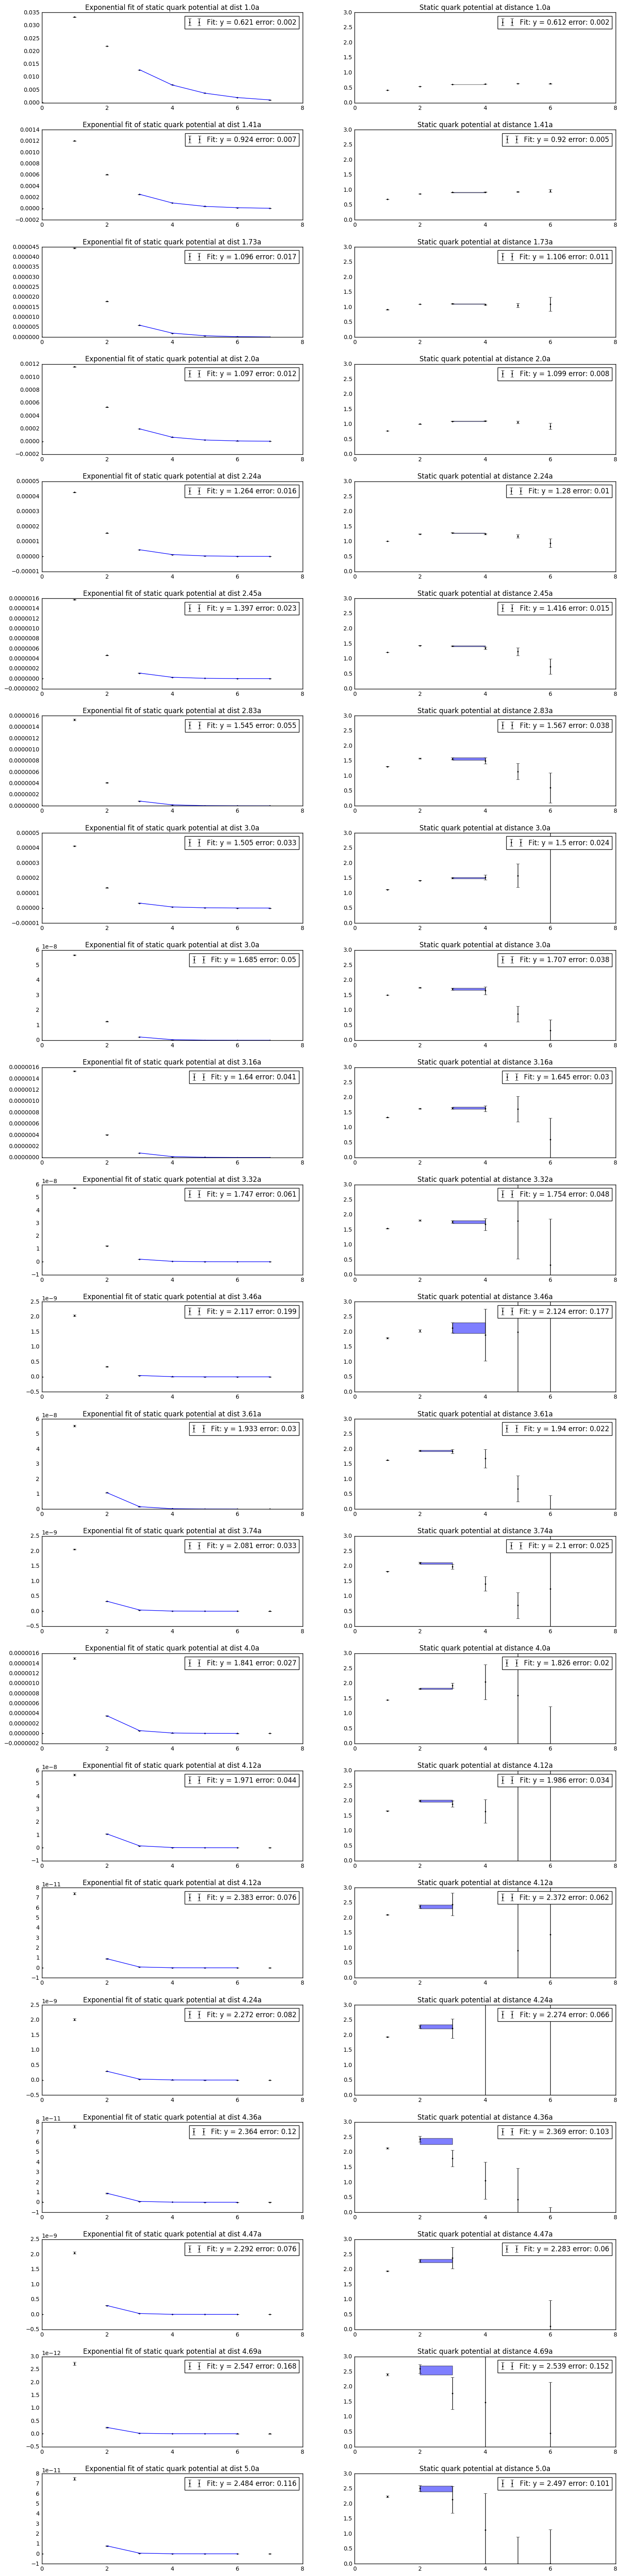

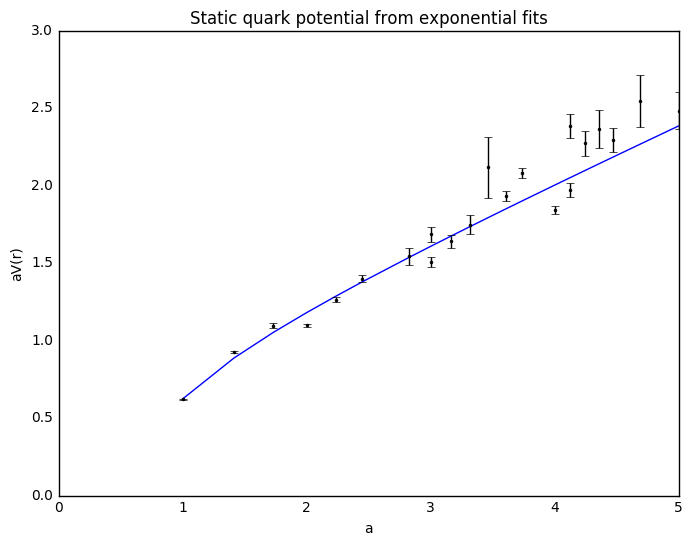

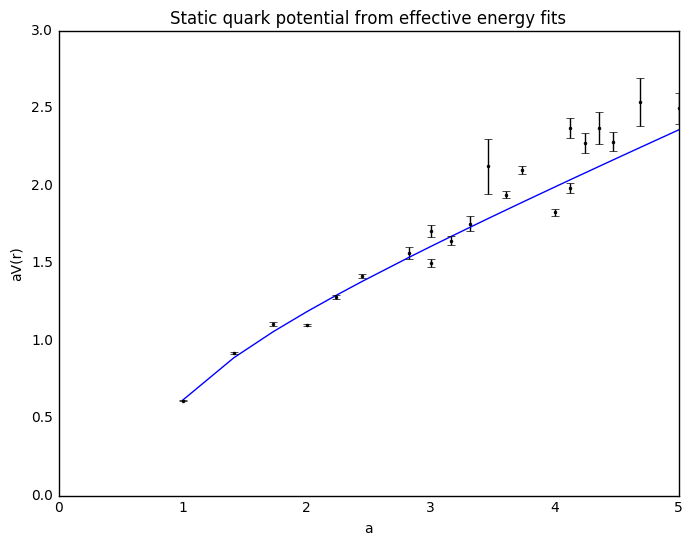

Exponential Fit: f(r)= 0.362571123031*r - 0.389273475101/r + 0.648915978229
Effective Fit: f(r)= 0.346411487228*r - 0.448319254844/r + 0.715924180243


In [66]:
generate_plots(fit_data, exp_t1=3, exp_t2=8, lin_t1=3, lin_t2=5)

In [11]:
improved_observable_configs = generate_smeared_observable_configs("improved_link_sum", 1.719, 0.797, 4)

Distance 1.0 computed
Distance 2.0 computed
Distance 3.0 computed
Distance 4.0 computed
Distance 1.41431356237 computed
Distance 2.2361679775 computed
Distance 3.16237766017 computed
Distance 2.2361679775 computed
Distance 2.82852712475 computed
Distance 3.60565127546 computed
Distance 3.16237766017 computed
Distance 3.60565127546 computed
Distance 4.24274068712 computed
Distance 4.12320562562 computed
Distance 4.472235955 computed
Distance 5.0001 computed
Distance 1.73225080757 computed
Distance 2.44968974278 computed
Distance 2.44968974278 computed
Distance 3.0002 computed
Distance 3.31682479036 computed
Distance 3.74185738677 computed
Distance 2.44968974278 computed
Distance 3.0002 computed
Distance 3.0002 computed
Distance 3.46430161514 computed
Distance 3.74185738677 computed
Distance 4.12330562562 computed
Distance 3.31682479036 computed
Distance 3.74185738677 computed
Distance 3.74185738677 computed
Distance 4.12330562562 computed
Distance 4.35909894354 computed
Distance 4.69061

In [12]:
data_save("improved_link_sum", 1.719, improved_observable_configs)

In [13]:
improved_fit_data = load_data("improved_link_sum", 1.719)

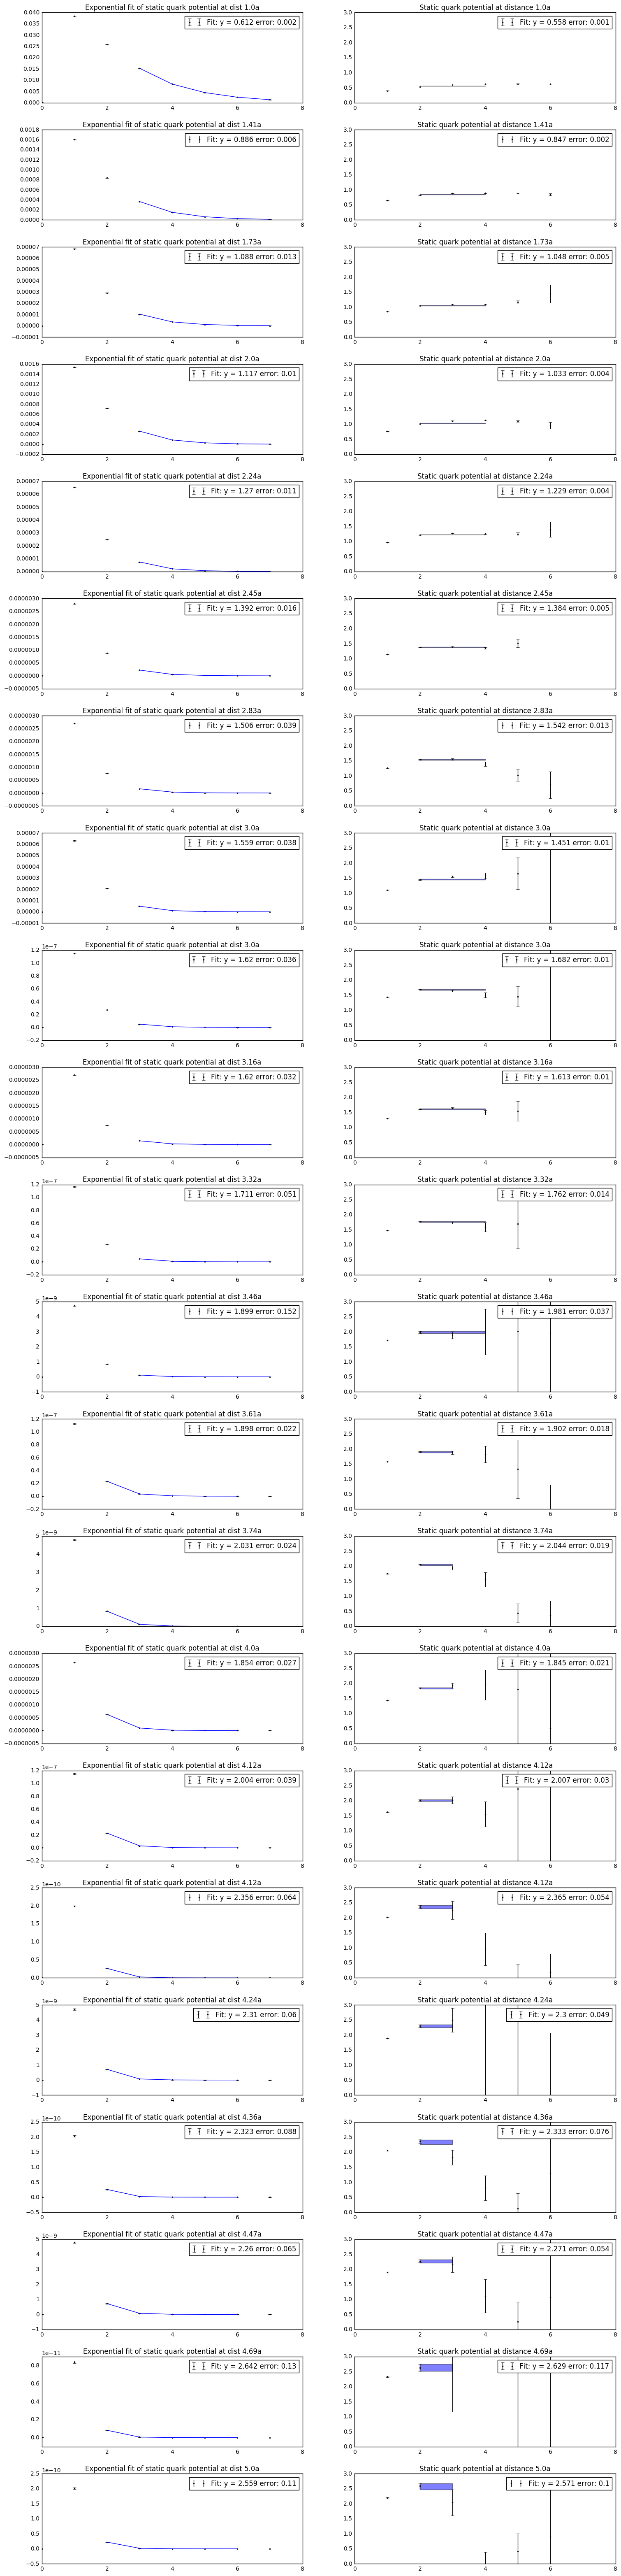

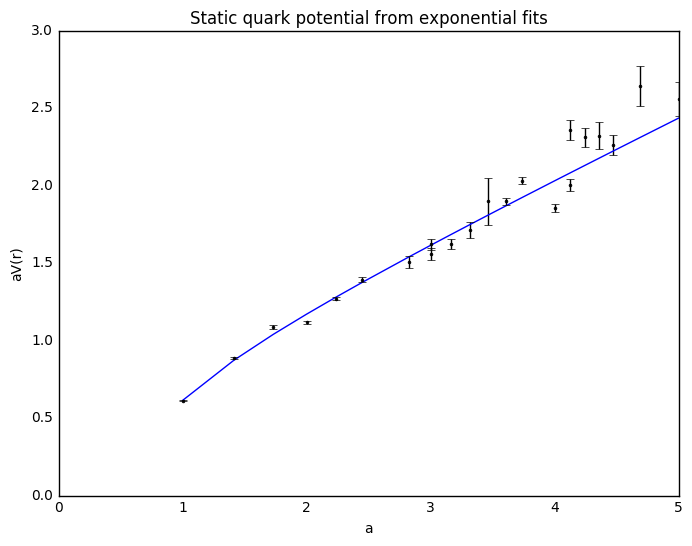

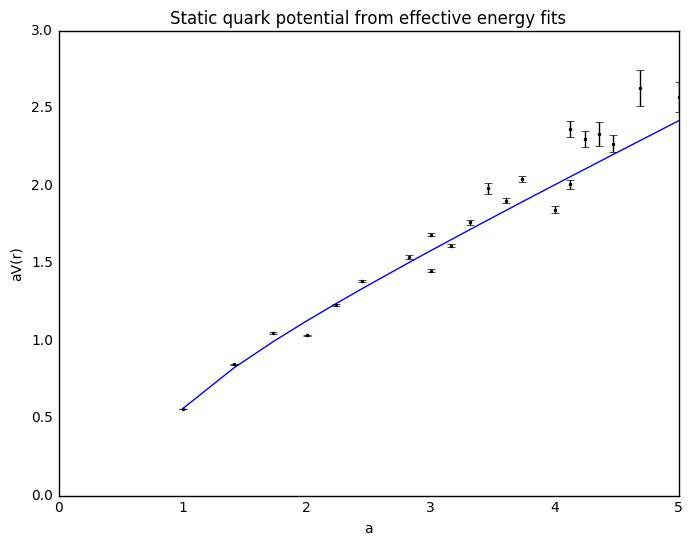

Exponential Fit: f(r)= 0.387824907022*r - 0.337781666805/r + 0.562878084901
Effective Fit: f(r)= 0.396476142272*r - 0.340041265765/r + 0.502646366197


In [17]:
generate_plots(improved_fit_data, exp_t1=3, exp_t2=8, lin_t1=2, lin_t2=5)

Smearing with u_0 still not working, works when u_0 = 1?
Smeared effective energy plateau's approach from below?
The time slice at which they plateau change with distance? Excited states have less of an effect for longer distance? 
I am fitting at later time slices to ignore the excited states, is this semi reasonable?